CarND-Advanced-Lane-Lines
===


### Imports


In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


#### Used code from the class exercises to initial camera calibration

In [320]:

def find_img_points_obj_points(imgpoints, objpoints, display=False):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')

    n_images = len(images)
    n_rows = n_images//4 + (n_images%4 > 0)
    if display:
        f, axarr = plt.subplots(n_images//4, 4, figsize=(15, 10))

    # Step through the list and search for chessboard corners
    for i, fname in enumerate(images):
        img = cv2.imread(fname)
        if img is None:
            print('Could not read: ', fname)
            continue

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            # Draw and display the corners
            if display:
                cv2.drawChessboardCorners(img, (9,6), corners, ret)
                axarr[i//4, i%4].imshow(img)
                axarr[i//4, i%4].set_title('corners found')
        else:
            if display:
                axarr[i//4, i%4].imshow(img)
                axarr[i//4, i%4].set_title('NOT found ' + fname)


    if display:
        plt.show()
    return imgpoints, objpoints

#### Again starting with the class exercise

In [935]:
class Camera():
    def __init__(self):
        #
        self.objpoints = []
        self.imgpoints = []
        self.mtx = 0
        self.dist = 0
        self.rvecs = []
        self.tvecs = []
        
        
def setup_undistort(cam, display=False):
    # Arrays to store object points and image points from all the images.
    objpoints = cam.objpoints
    imgpoints = cam.imgpoints

    imgpoints, objpoints = find_img_points_obj_points(imgpoints, objpoints)

    # Read in an image
    img = cv2.imread('camera_cal/calibration1.jpg')
    if img is None:
        print('Could not read: ', fname)

    ret, cam.mtx, cam.dist, cam.rvecs, cam.tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2], None, None)

def undistort(image, cam, display=False):
    undist = cv2.undistort(image, cam.mtx, cam.dist, None, cam.mtx)

    if display:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(image)
        ax1.set_title('Original Image', fontsize=50)
        ax2.imshow(undist)
        ax2.set_title('Undistorted Image', fontsize=50)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        plt.show()
    return undist

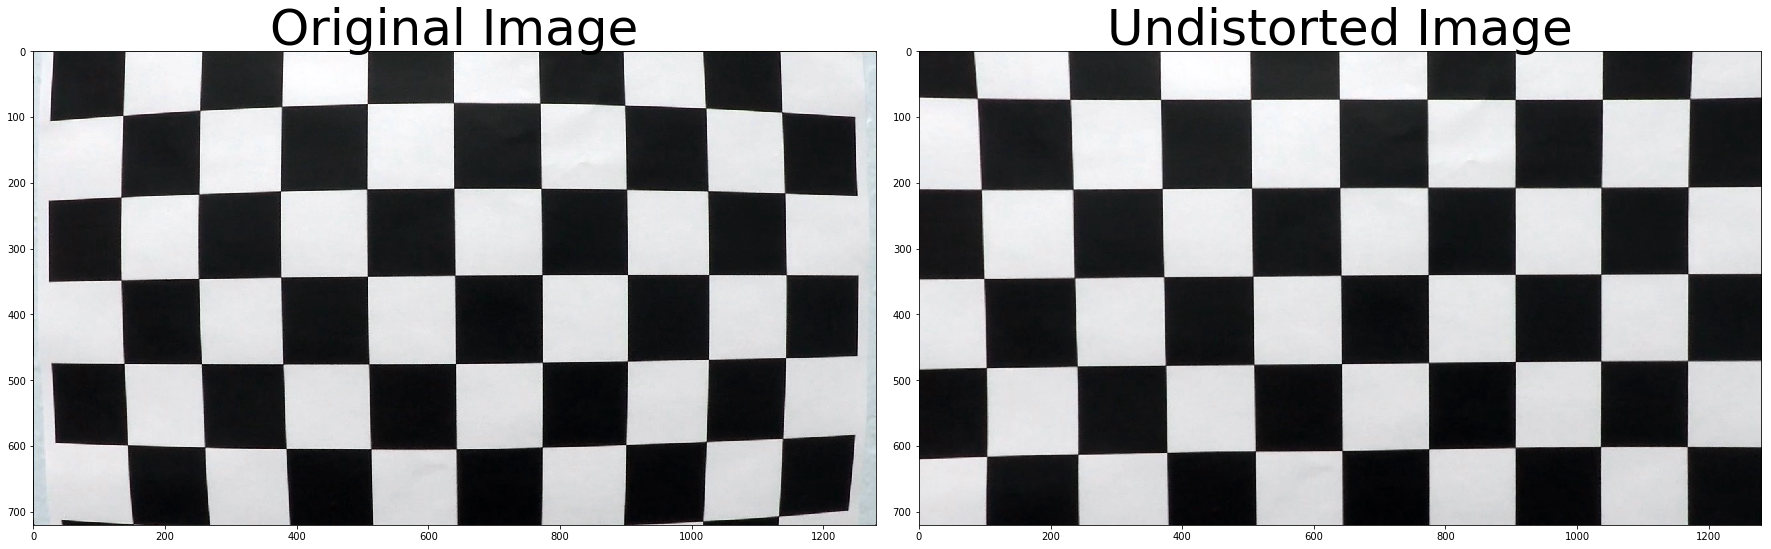

In [936]:
cam = Camera()
setup_undistort(cam)
image = cv2.imread('camera_cal/calibration1.jpg')
undistorted = undistort(image, cam, display=True)

Minimal change can be seen in the undistorted image.  It is most noticeable in the hood of the car.

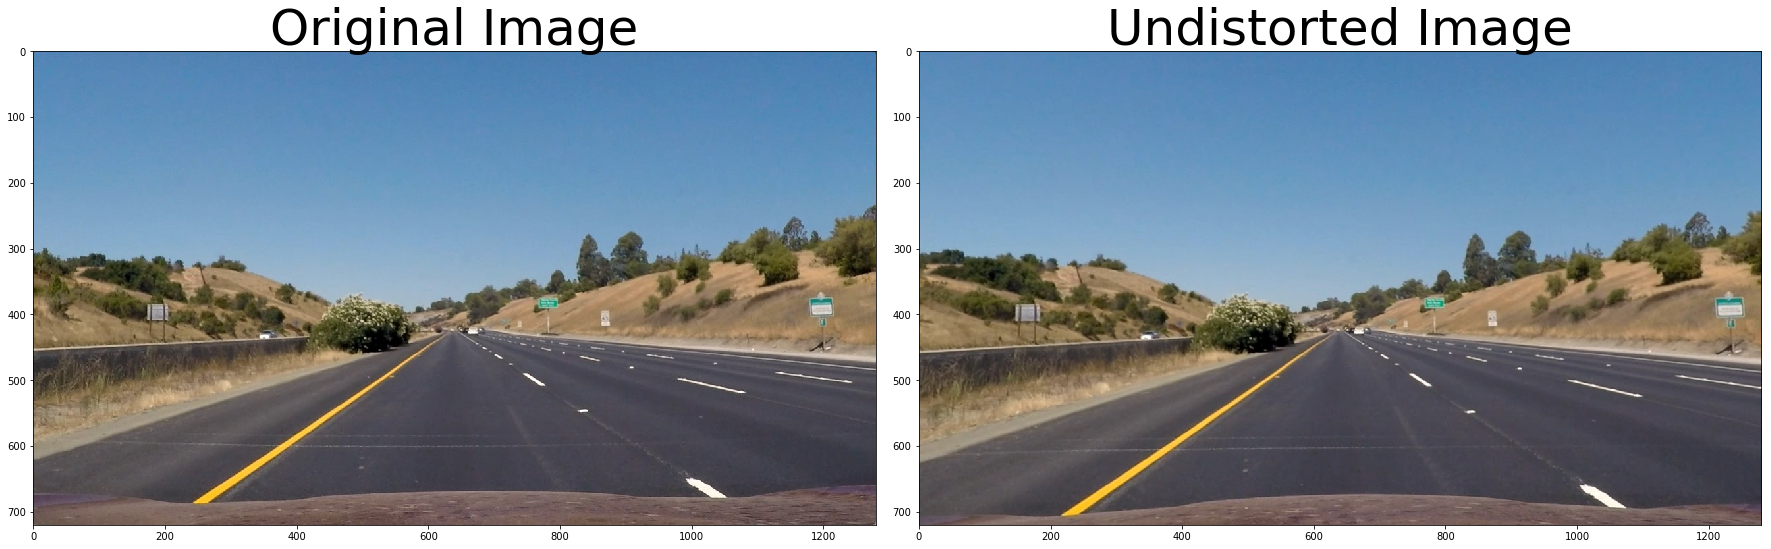

True

In [937]:
img = mpimg.imread('test_images/straight_lines1.jpg')
if img is None:
    print('Could not read: ', fname)
undistorted = undistort(img, cam, display=True)
cv2.imwrite('test_images/straight_lines1_unwarped.jpg', undistorted)

A couple helper functions from my prior Traffic sign project to display multiple images.

In [4]:
def show_list_images(images):
    n_col = 3
    n_row = len(images) // n_col + (len(images) % n_col > 0)
    f, axarr = plt.subplots(n_row, n_col, figsize=(n_row *5, 10))
    for i, image in enumerate(images):        
        axarr[i//n_col, i%n_col].imshow(image)
    for i in range(len(images), n_col * n_row):        
        axarr[i//n_col, i%n_col].axis('off')

    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=.5)
    plt.show()


In [7]:
def read_list_images(files, ilist):
    for i, test_image_file in enumerate(files):
        test_image = cv2.imread(test_image_file, cv2.IMREAD_COLOR)
        b,g,r = cv2.split(test_image)
        test_image = cv2.merge([r,g,b])
        ilist.append(test_image)
    return 


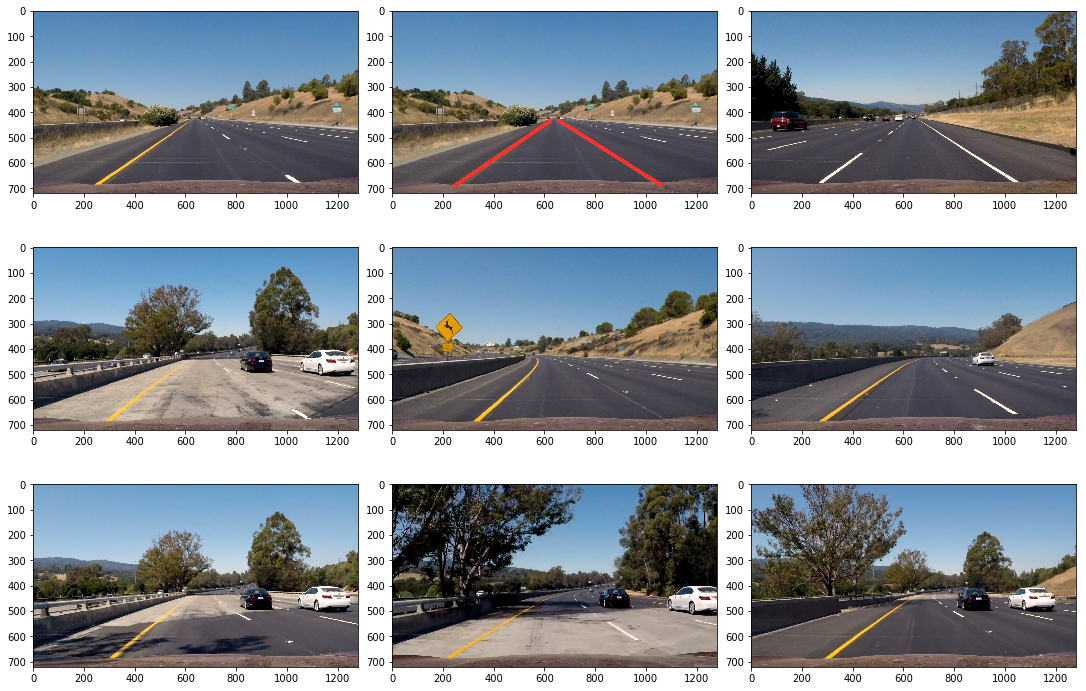

In [10]:
test_image_list = []
read_list_images(glob.glob("test_images/*.jpg"), test_image_list)
show_list_images(test_image_list)

## Process the individual frame images to extract the lanes lines.

This function extract_lane_lines() currently uses the everthing including the kitchen
sink approach.  It uses:
 - R channel Threshold
 - S Channel Threshold
 - H Channel Threshold
 - Yellow and White mask Threshold(s)
 - X Gradient Threshold
 
It uses a voting method to determine a second threshold.  The X gradient gets 2 votes the
others get 1.

When analyzed on the challenge video, the yellow/white masks primary contribution seems to
be noise.  It should probably be dropped.

The R channel is really about the only required data for the basic video, but has significant
problems on the challenge video.

This is the function that would likely benefit the most from significant work on the parameters
of each channel and the addition of some type of adaption to changing conditions that change
the parameters of the search for features.



In [730]:
def extract_lane_lines(image, display=False, filter='c3'):
    
    # Extract RGB components, note this assumares RGB input
    R = image[:,:,0]
    G = image[:,:,1]
    B = image[:,:,2]
    rthresh = (220, 255)
    rbinary = np.zeros_like(R)
    rbinary[(R > rthresh[0]) & (R <= rthresh[1])] = 1

    wthresh = (220, 255)
    wbinary = np.zeros_like(R)
    wbinary[(R > rthresh[0]) & (G > rthresh[0]) & (B > rthresh[0])] = 1

    # Compute a combination yellow and white image similar to my first lane finding project
    # white,
    white_pixels = cv2.inRange(image, np.uint8([220, 220, 200]), np.uint8([255, 255, 255]))
    # yellow
    yellow_pixels = cv2.inRange(image, np.uint8([180, 180,   0]), np.uint8([255, 255, 255]))
    yw_pix = cv2.bitwise_or(white_pixels, yellow_pixels)
    ywbinary = np.zeros_like(R)
    ywbinary[(yw_pix > 1)] = 1

    # Gray scale for gradient thresholds
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    
    # Take the gradient in x and y separately
    sobel_kernel=9
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel) # Take the derivative in x
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    sxbinary = np.zeros_like(scaled_sobelx)
    sx_thresh=(20, 255)
    sxbinary[(scaled_sobelx >= sx_thresh[0]) & (scaled_sobelx <= sx_thresh[1])] = 1

    # Calculate the magnitude
    sobel = np.sqrt(sobelx**2 + sobely**2)
    scaled_sobel = np.uint8(255*sobel/np.max(sobel))
    mag_thresh = (50, 255)
    smbinary = np.zeros_like(R)
    smbinary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1

    # Extract HLS components, still assumares RGB input
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    
    # Compute an H channel threshold
    hthresh = (15, 80)
    hbinary = np.zeros_like(H)
    hbinary[(H > hthresh[0]) & (H <= hthresh[1])] = 1

    # Compute an S channel threshold
    sthresh = (150, 255)
    sbinary = np.zeros_like(S)
    sbinary[(S > sthresh[0]) & (S <= sthresh[1])] = 1

    combo = rbinary + sbinary + hbinary + ywbinary + sxbinary + sxbinary
    c2binary = np.zeros_like(S)
    c3binary = np.zeros_like(S)
    c4binary = np.zeros_like(S)
    c5binary = np.zeros_like(S)
    c2binary[(combo >=2)] = 1
    c3binary[(combo >=3)] = 1
    c4binary[(combo >=4)] = 1
    c5binary[(combo >=5)] = 1
    
    def display_image_features():
        f, axarr = plt.subplots(6, 2, figsize=(24, 30))
        f.tight_layout()

        axarr[0,0].imshow(image)
        axarr[0,0].set_title('Original Image', fontsize=30)
        axarr[0,1].imshow(rbinary, cmap="gray")
        axarr[0,1].set_title('R channel', fontsize=30)

        axarr[1,0].imshow(sbinary, cmap="gray")
        axarr[1,0].set_title('S Channel', fontsize=30)

        axarr[1,1].imshow(hbinary, cmap="gray")
        axarr[1,1].set_title('H Channel', fontsize=30)

        axarr[2,0].imshow(wbinary, cmap="gray")
        axarr[2,0].set_title('white', fontsize=30)

        axarr[2,1].imshow(ywbinary, cmap="gray")
        axarr[2,1].set_title('yellow/white', fontsize=30)

        axarr[3,0].imshow(sxbinary, cmap="gray")
        axarr[3,0].set_title('sx', fontsize=30)
        axarr[3,1].imshow(smbinary, cmap="gray")
        axarr[3,1].set_title('sm', fontsize=30)

        axarr[4,0].imshow(c2binary, cmap="gray")
        axarr[4,0].set_title('c2', fontsize=30)
        axarr[4,1].imshow(c3binary, cmap="gray")
        axarr[4,1].set_title('c3', fontsize=30)
        axarr[5,0].imshow(c4binary, cmap="gray")
        axarr[5,0].set_title('c4', fontsize=30)
        axarr[5,1].imshow(c4binary, cmap="gray")
        axarr[5,1].set_title('c5', fontsize=30)

        axarr[5,1].axis('off')
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        plt.show()
    if display:
        display_image_features()
    if filter == 'c4':
        return c4binary
    return c3binary
    

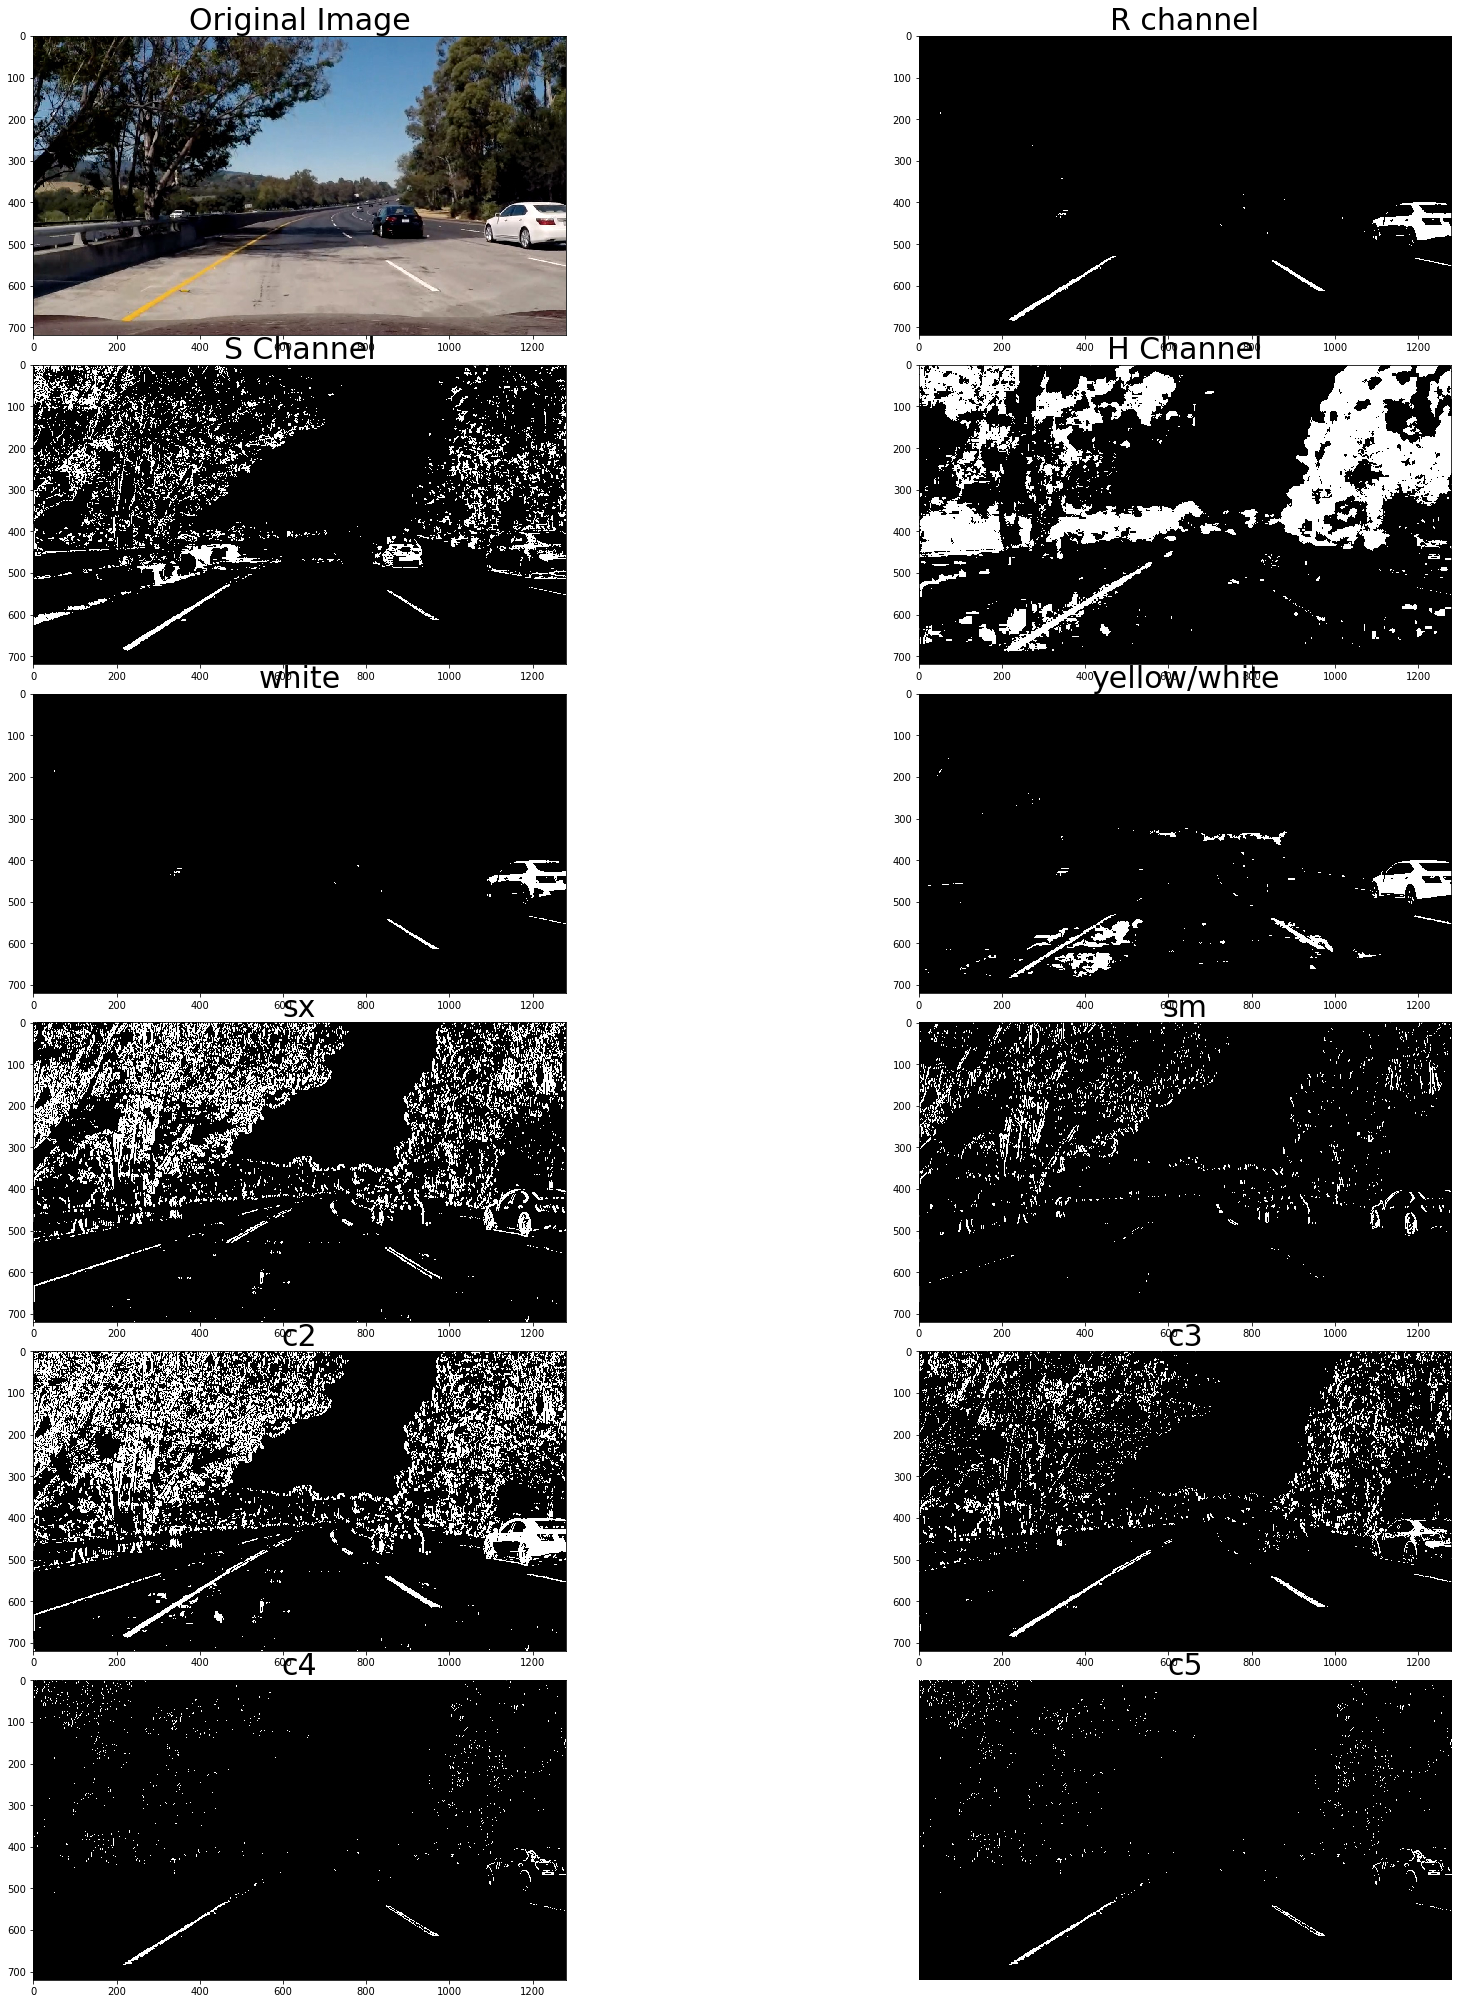

In [731]:

image = mpimg.imread('test_images/test5.jpg')
_ = extract_lane_lines(image, display=True)


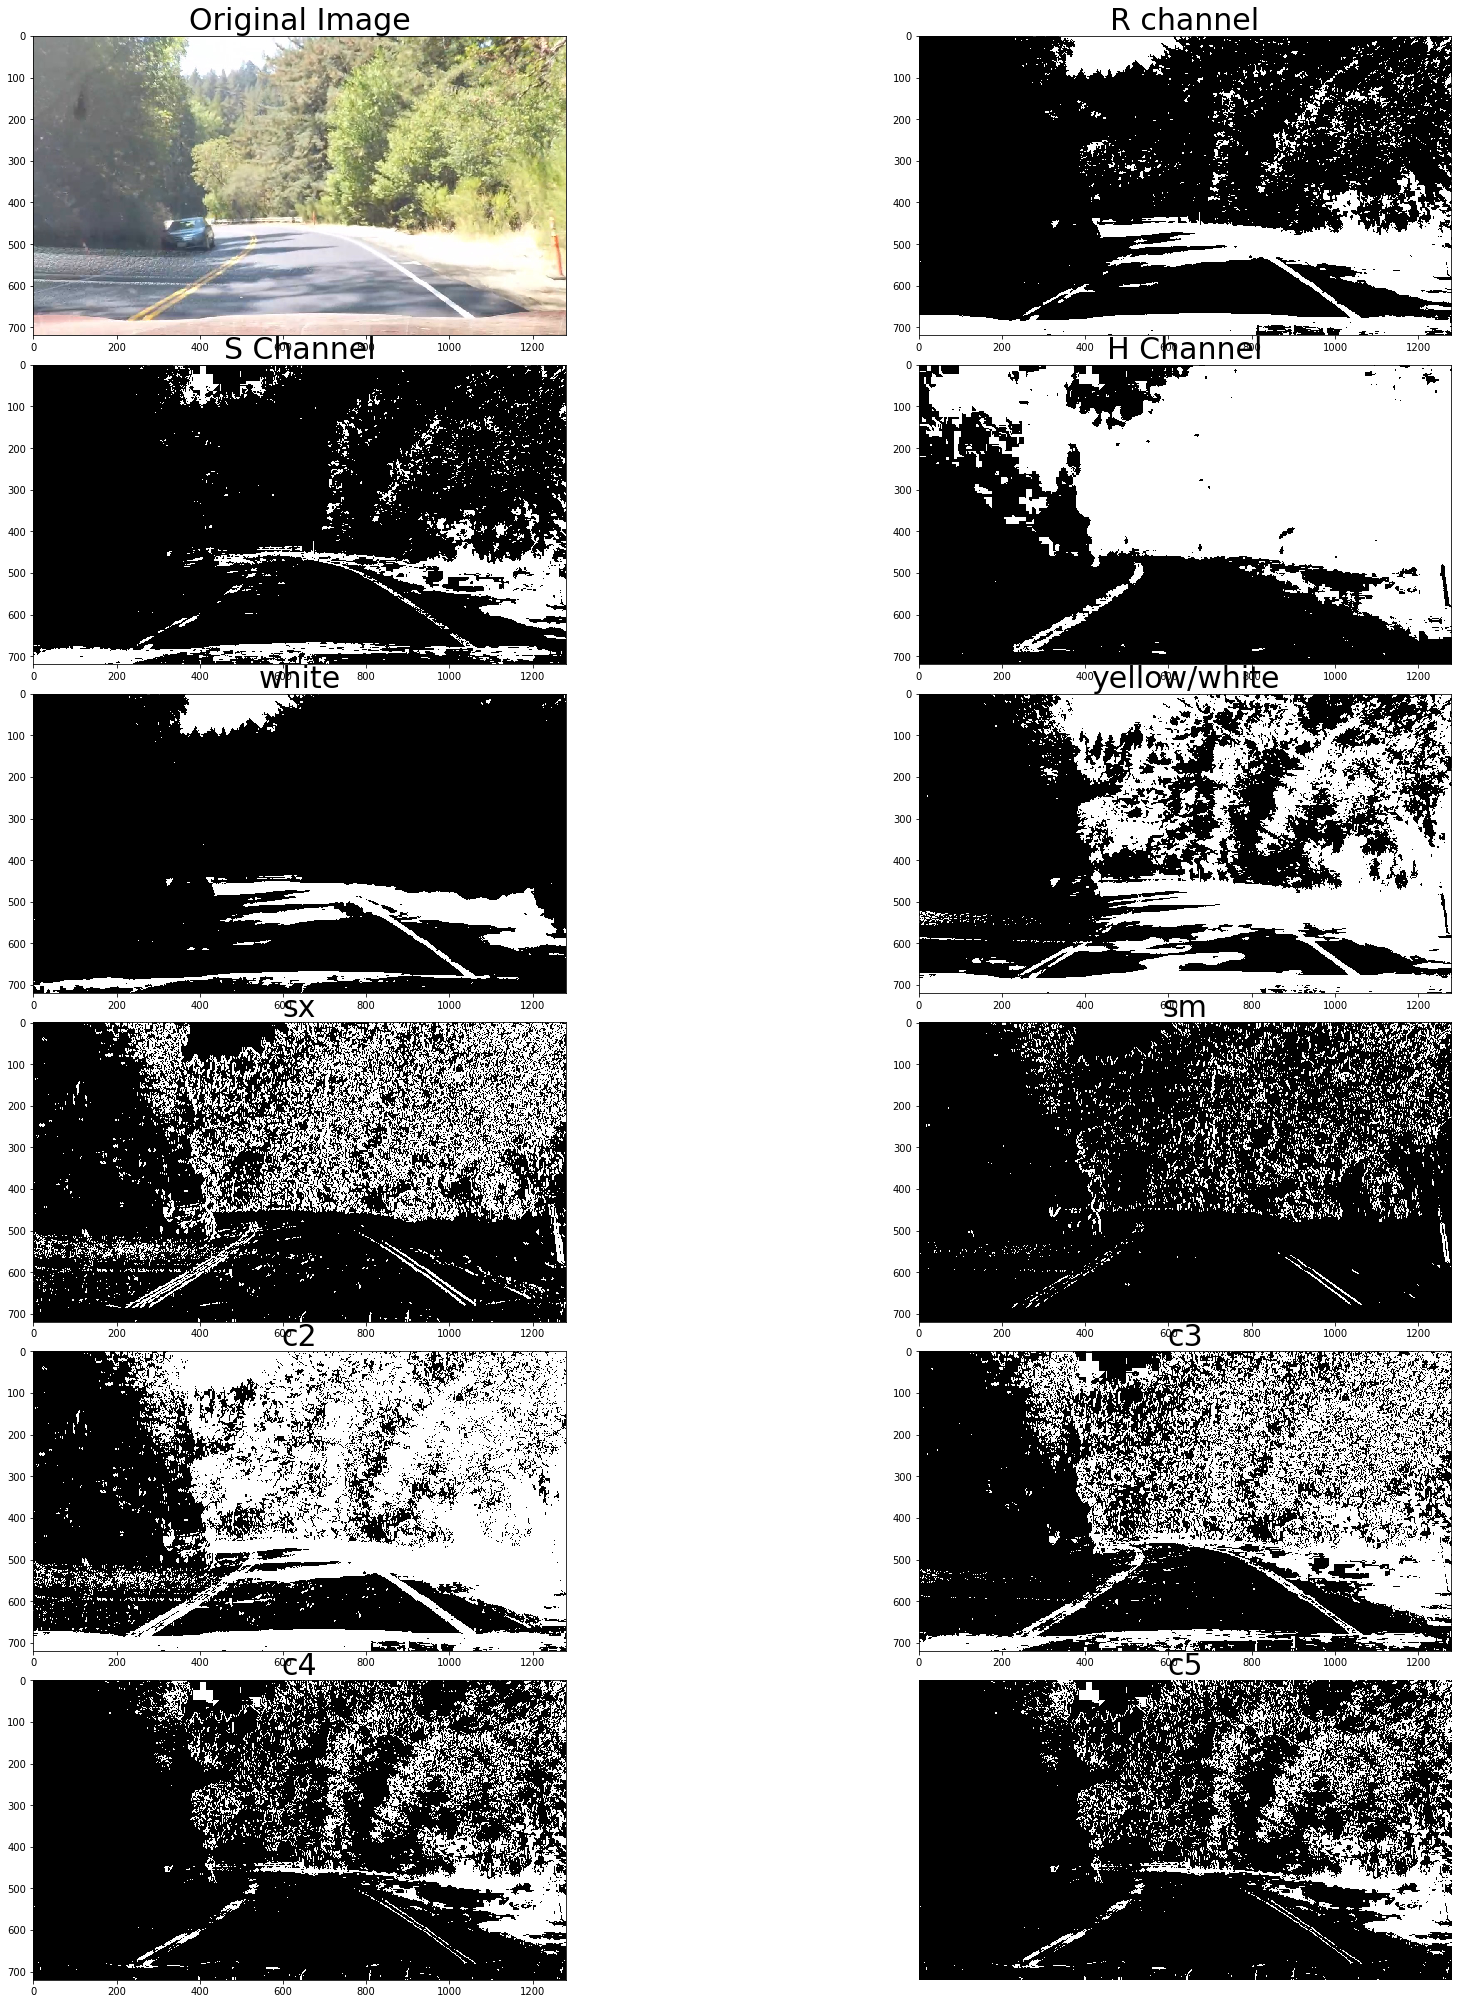

In [726]:
image = mpimg.imread('test_images/challenge_1.jpg')
_ = extract_lane_lines(image, display=True)


## Image Transform
    
    Perform an image transform to map an image to a top view/ map view type image.

In [1037]:
transform_left_intercept = 230
transform_right_intercept = 1070

def top_view_setup():
    bl = (transform_left_intercept, 720-28)
    br = (transform_right_intercept, 720-28)
    #tl = (598, 720-275) # Original trapezoid from eyeballing image
    #tr = (683, 720-275)
    tl = (550, 720-250) # Adjustment for straightness, also shortens horizon for challenge video
    tr = (730, 720-250)

    # Manually tweaked trapezoid adjusted to make straight lines look straight on the top down view.
    
    # Also adjusted to bring in the lower lane offsets to get more of the lane in view on curved roads.
    nbl = (bl[0]+100, bl[1])  
    nbr = (br[0]-100, br[1])
    ntl = (bl[0]+100, 0)
    ntr = (br[0]-100, 0)

    src = np.float32([tl, tr, bl, br])
    dst = np.float32([ntl, ntr, nbl, nbr])
    
    # Use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    return M, Minv

def top_view_transform(image, M):
    # Use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(image, M, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR)
    
    # Return image. Return Minv for later use to unwarp
    return warped

# Testing utility function
def top_view(image):
    M, Minv = top_view_setup()
    warped = top_view_transform(image, M)
    # Return image. Return Minv for later use to unwarp
    return warped, Minv


In [961]:
## Demonstration of filtered image and top view transform

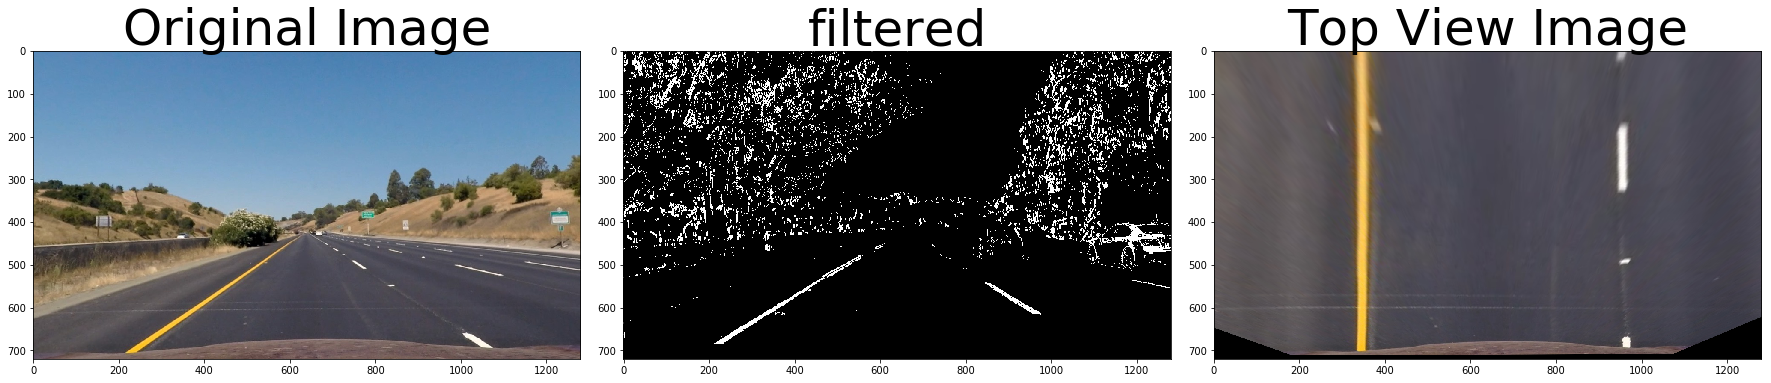

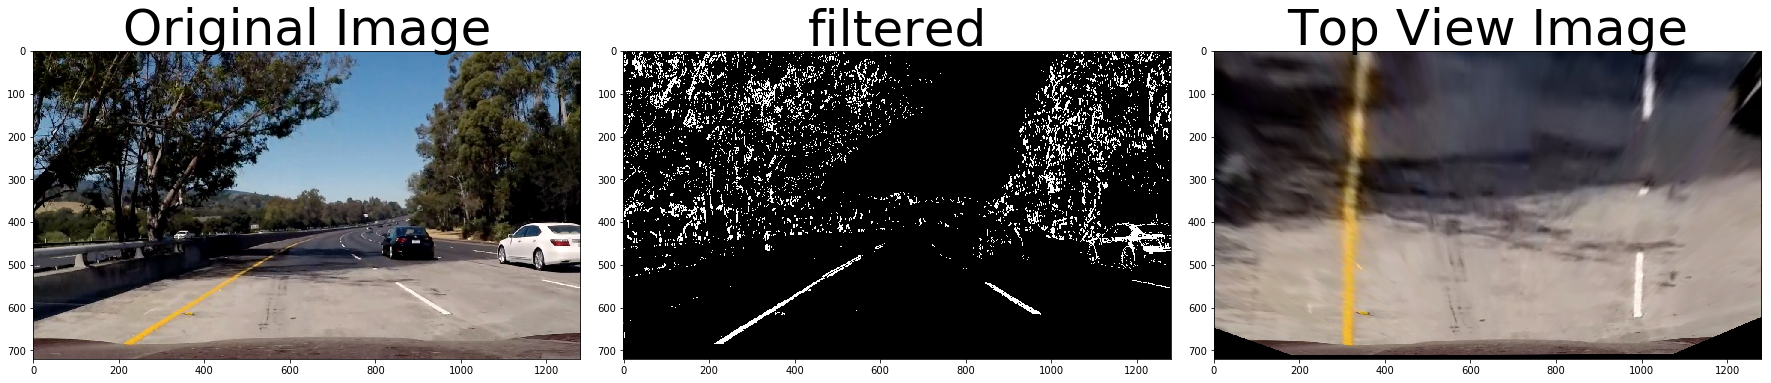

In [947]:
image = mpimg.imread('test_images/straight_lines1_undistorted.jpg')
lanelines = extract_lane_lines(image, display=False)

warped, Minv = top_view(image)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(ll_image)
ax2.set_title('filtered', fontsize=50)
ax3.imshow(warped)
ax3.set_title('Top View Image', fontsize=50)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

image = mpimg.imread('test_images/test5.jpg')
lanelines = extract_lane_lines(image, display=False)
scaled_ll = np.uint8(255*lanelines)
ll_image = np.dstack((scaled_ll, scaled_ll, scaled_ll))
warped, Minv = top_view(image)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(ll_image)
ax2.set_title('filtered', fontsize=50)
ax3.imshow(warped)
ax3.set_title('Top View Image', fontsize=50)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()


### Histogram test on very easy image

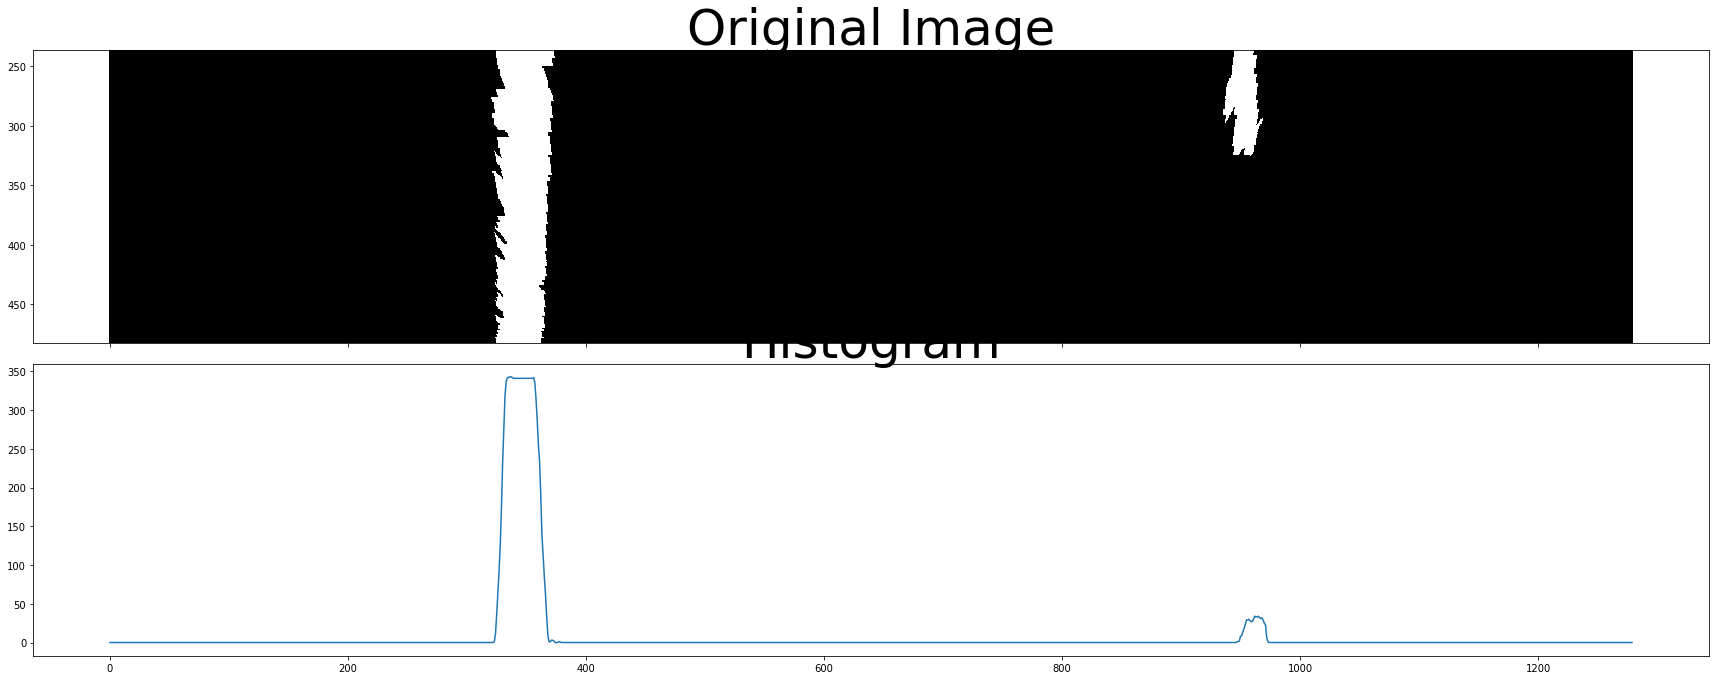

In [967]:
image = mpimg.imread('test_images/straight_lines1_undistorted.jpg')
filtered = extract_lane_lines(image, display=False)

warped, _ = top_view(filtered)

histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24, 9), sharex=True)
f.tight_layout()
ax1.imshow(warped, cmap="gray")
ax1.set_title('Original Image', fontsize=50)
ax2.plot(histogram)
ax2.set_title('Histogram', fontsize=50)
plt.show()


## Sliding Window Search

This code was taken very heavily from the Project lesson 33:

https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/2b62a1c3-e151-4a0e-b6b6-e424fa46ceab/lessons/40ec78ee-fb7c-4b53-94a8-028c5c60b858/concepts/c41a4b6b-9e57-44e6-9df9-7e4e74a1a49a

A limited amount of record keeping and debug material was added.


In [1004]:
def initial_sliding_windows(binary_warped, display=False, debug=False):
    
    if binary_warped.shape != (720, 1280):
        print("Expecting shape 720, 1280, found shape: ", binary_warped.shape)

    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    top_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(top_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(top_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # If unable to find lines or a fit, return failure
    if len(left_lane_inds) == 0 or len(right_lane_inds) == 0 or leftx.size == 0 or rightx.size == 0:
        top_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        if debug:
            plt.imshow(top_img)
            plt.show()
        return False, [], [], [], top_img

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    l_line.current_fit = left_fit
    r_line.current_fit = right_fit
    
    l_line.add_radius(find_radius_of_curvature(lefty, leftx))
    r_line.add_radius(find_radius_of_curvature(righty, rightx))

    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    if display or debug:
        top_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        top_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        #top_img[left_fitx, ploty] = [255, 255, 0]
        #top_img[right_fitx, ploty] = [255, 255, 0]

        if display:
            plt.imshow(top_img)
            plt.plot(left_fitx, ploty, color='yellow')
            plt.plot(right_fitx, ploty, color='yellow')
            plt.xlim(0, 1280)
            plt.ylim(720, 0)
            plt.show()
    return True, left_fit, right_fit, ploty, top_img

## Test of the initial sliding window function

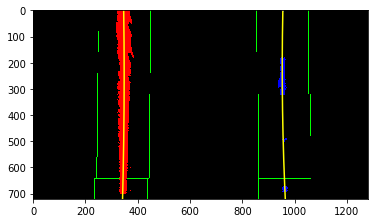

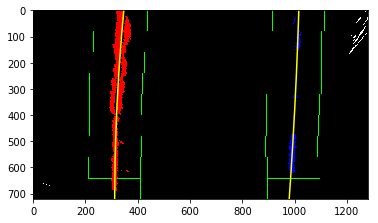

In [970]:
image = mpimg.imread('test_images/straight_lines1_undistorted.jpg')
filtered = extract_lane_lines(image, display=False)
warped, _ = top_view(filtered)
found, _, _, _, _ = initial_sliding_windows(warped, display=True)

image = mpimg.imread('test_images/test5.jpg')
filtered = extract_lane_lines(image, display=False)
warped, _ = top_view(filtered)
found, _, _, _, _ = initial_sliding_windows(warped, display=True)

## The continued sliding window function

This again was taken almost unchanged from the class lesson # 33.

Again I added error cases and debug visualization.


In [1005]:
def cont_sliding_windows(binary_warped, left_fit, right_fit, display=False, debug=False):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    if len(left_lane_inds) == 0 or len(right_lane_inds) == 0 or leftx.size == 0 or rightx.size == 0:
        if debug:
            print(nonzero[0].shape)
            print(nonzero[1].shape)
            print(left_lane_inds)
            print(right_lane_inds)
            print(type(rightx))
            print(leftx.shape)
            plt.imshow(binary_warped)
            plt.show()
        top_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        return False, left_fit, right_fit, [], top_img

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    l_line.current_fit = left_fit
    r_line.current_fit = right_fit

    l_line.add_radius(find_radius_of_curvature(lefty, leftx))
    r_line.add_radius(find_radius_of_curvature(righty, rightx))

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    # And you're done! But let's visualize the result here as well
    # Create an image to draw on and an image to show the selection window
    top_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(top_img)
    # Color in left and right line pixels
    top_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    top_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    if display or debug:
        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))

        yd1 = binary_warped.shape[0]-200
        yd2 = binary_warped.shape[0]-400
        yd1_left = (int(left_fitx[yd1]), int(ploty[yd1]))
        yd1_right = (int(right_fitx[yd1]), int(ploty[yd1]))
        yd2_left = (int(left_fitx[yd2]), int(ploty[yd2]))
        yd2_right = (int(right_fitx[yd2]), int(ploty[yd2]))
        #print((int(left_fitx[yd1]), int(ploty[yd1])), (int(right_fitx[yd1]), int(ploty[yd1])) , (255,255, 0))
        #print(yd1_left, yd1_right , yd1_right[0] - yd1_left[0], (255,255, 0))
        debug_data.yd1.append(yd1_right[0] - yd1_left[0])
        debug_data.yd2.append(yd2_right[0] - yd2_left[0])

        cv2.line(window_img, yd1_left, yd1_right , (255,255, 0), thickness=5)
        cv2.line(window_img, yd2_left, yd2_right , (255,255, 0), thickness=5)

        top_img = cv2.addWeighted(top_img, 1, window_img, 0.3, 0)
        
        # Brutally slow method of putting plot on the debug image.
        # Do not use unless last resort.
        if debug_data.showfit:
            fig = plt.figure(figsize=(18,10))
            plt.plot(left_fitx, ploty, color='red')
            plt.plot(right_fitx, ploty, color='red')
            plt.xlim(0, 1280)
            plt.ylim(720, 0)
            plt.axis('Off')
            fig.canvas.draw()
            # convert canvas to image
            width, height = fig.get_size_inches() # * fig.get_dpi()
            plot_img = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
            plot_img  = plot_img.reshape(fig.canvas.get_width_height()[::-1] + (3,))        
            #plot_img[0:720,0:1280,:] = cv2.resize(plot_img,(1280,720))
            plot_img = cv2.resize(plot_img,(1280,720))
            plt.close()
            fig.clf()
            _ = plt.clf()

            # Convert to BGR
            plot_img = cv2.cvtColor(plot_img, cv2.COLOR_RGB2BGR)
            top_img = cv2.addWeighted(top_img, 1, plot_img, 0.3, 0)

        if display:
            _ = plt.figure(figsize=None)
            plt.imshow(top_img)
            plt.plot(left_fitx, ploty, color='yellow')
            plt.plot(right_fitx, ploty, color='yellow')
            plt.xlim(0, 1280)
            plt.ylim(720, 0)
            _ = plt.show()

    return True, left_fit, right_fit, ploty, top_img

### Test the same image on both the initial and continued sliding window functions.

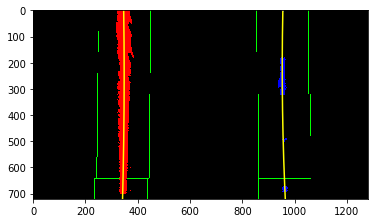

continue


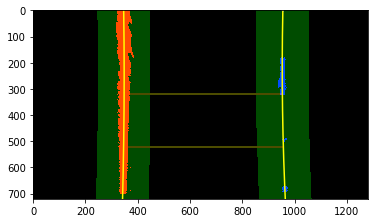

In [975]:
image = mpimg.imread('test_images/straight_lines1_undistorted.jpg')
filtered = extract_lane_lines(image, display=False)

warped, Minv = top_view(filtered)
found, left_fit, right_fit, ploty, _ = initial_sliding_windows(warped, display=True)
print("continue")
found, left_fit, right_fit, ploty, _ = cont_sliding_windows(warped, left_fit, right_fit, display=True)

## Draw Final


In [1109]:
def draw_final(image, left_fit, right_fit, ploty, display=True):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    if l_line.found == False or r_line.found == False:
        return image
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, process_data.Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    
    dist_fc, lorigin, rorigin = dist_from_center(left_fit, right_fit)

    if process_data.need_update() == True:
        green = [0, 255, 0]
        font = cv2.FONT_HERSHEY_DUPLEX
        fsize = 1.5
        fcolor = green
        fthick = 4

        text_img = np.dstack((warp_zero, warp_zero, warp_zero))
        if dist_fc < 0:
            text = "Left of Center : " + ' {: 2.2f}'.format(abs(dist_fc))
        else:
            text = "Right of Center : " + ' {: 2.2f}'.format(dist_fc)
        cv2.putText(text_img, text, (0,60), font, fsize, fcolor, fthick)
        text = "L radius: " + '{: 3.1f}'.format(l_line.get_radius()) + " km"
        cv2.putText(text_img, text, (0,100), font, fsize, fcolor, fthick)
        text = "R radius: " + '{: 3.1f}'.format(r_line.get_radius()) + " km"
        cv2.putText(text_img, text, (800,100), font, fsize, fcolor, fthick)
        process_data.text_image = text_img
        result = cv2.addWeighted(result, 1, text_img, 0.9, 0)
    else:
        result = cv2.addWeighted(result, 1, process_data.text_image, 0.9, 0)
    process_data.framecount += 1

    if display:
        plt.imshow(result)
        plt.show()
    return result

## Test basic pipeline, end to end

In [1077]:
image = mpimg.imread('test_images/straight_lines2.jpg')
cam = Camera()
setup_undistort(cam)

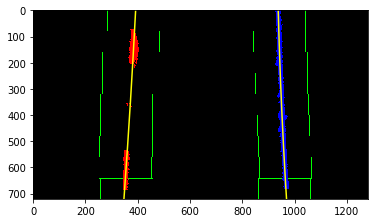

continue


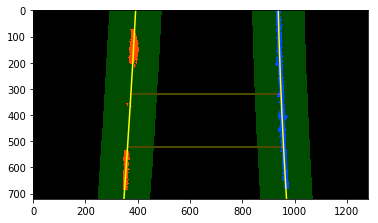

continue


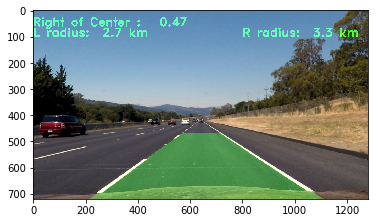

In [1103]:

undistorted = undistort(image, cam, display=False)
filtered = extract_lane_lines(image, display=False)
warped, Minv = top_view(filtered)
l_line = Line()
r_line = Line()
found, left_fit, right_fit, ploty, _ = initial_sliding_windows(warped, display=True)
print("continue")
found, left_fit, right_fit, ploty, _ = cont_sliding_windows(warped, left_fit, right_fit, display=True)
print("continue")
debug_data = DebugData()

l_line.found = True
r_line.found = True
_ = draw_final(undistorted, left_fit, right_fit, ploty, display=True)

In [1081]:
l_line.radius_list


[]

## Simple classes

The Line class as suggested in the tips and tricks.  It could be used to keep some additional data and
limit the number of parameters passed.

DebugData and ProcessData are a couple simple singletons to simplify the flow of control.


In [1068]:
class Line():
    def __init__(self):
        # First time through the pipeline?
        self.found = False  
        self.fit = []
        self.current_fit = []
        self.radius_list = []
    def add_radius(self, num):
        self.radius_list.append(num)
        if len(self.radius_list) > 10: self.radius_list[:1]=[]
    def get_radius(self):
        return sum(self.radius_list)/len(self.radius_list)
        
class DebugData():
    def __init__(self):
        self.on = False
        self.showfit = False
        self.text_image = None
        self.framecount = 0
        self.allframe = False
        self.errorframe = False
        # list of fits failing sanity checks
        self.left_fit = []
        self.right_fit = []
        self.yd1 = []
        self.yd2 = []
    def need_update(self):
        if type(self.text_image) is type(None) or self.framecount % 20 == 0 or self.allframe or self.errorframe:
            return True

class ProcessData():
    def __init__(self, debug=False):
        self.debug = debug
        self.setup = False
        self.M = 0
        self.Minv = 0
        self.text_image = None
        self.framecount = 0
    def need_update(self):
        if type(self.text_image) is type(None) or self.framecount % 20 == 0:
            return True



## Radius of curvature

Formula for radius of curvature taken from: 
    https://www.intmath.com/applications-differentiation/8-radius-curvature.php
    
By the time I implemented this, somehow I forgot about the project lesson that 
covered the radius of curvature.  Googling I found the same formula.  I really 
only ended up with a difference in the distance per y pixel value which is 
explained below.


In [1027]:
# Nominal lane width per pixel, 3.7m per lane / approx 700 pixels avg width.
# The numeric measurement from center may be off, but the error will be proportional
# to distance from center.
width_meter_pixel = 3.7 / 700

# Top view shows about 1.5 cycles of dashed lines at 40ft per dash plus space
# Note this is sensitive to the prespective transform.  Really should be based on it.
height_meter_pixel = 18 / 720

def find_radius(fit):
    num = (1 + (2 * fit[0] + fit[1])**2)**1.5
    denom = abs(2*fit[0])
    radius = num / denom
    return radius / 1000

def find_radius_of_curvature(y, x):
    fit = np.polyfit(y * height_meter_pixel, x * width_meter_pixel, 2)
    return find_radius(fit)

def dist_from_center(left_fit, right_fit):
    # does max y intercept makes sense, at the bottom of the image
    ymax = warped.shape[0]
    xmid = warped.shape[1]/2
    lorigin = left_fit[0] * ymax**2 + left_fit[1] * ymax + left_fit[2]
    rorigin = right_fit[0] * ymax**2 + right_fit[1] * ymax + right_fit[2]

    position = (lorigin + rorigin)/2
    dist_fc = (position - xmid) * width_meter_pixel
    return dist_fc, lorigin, rorigin


## Sanity checks

### Check of the fit parameters for rough parallelism of the right and left lines.
### Check if the radius of curvature is wildy different between the right and left lines.


In [1066]:
def sanity_check_lines(warped, left_fit, right_fit, display=False, debug=False):
    warncolor = False
    
    # Limits selected from observation on challenge video, are somewhat arbitrary
    if left_fit[0]-right_fit[0] > .001 or \
            left_fit[1]-right_fit[1] > .8 or \
            abs(left_fit[2]-right_fit[2]) > 1100 or \
            abs(left_fit[2]-right_fit[2]) < 400:
        lostlines = True
        debug_data.left_fit.append(left_fit)
        debug_data.right_fit.append(right_fit)
    else:
        lostlines = False


    # TODO Need to also put this somewhere I can write on the main image.
    dist_fc, lorigin, rorigin = dist_from_center(left_fit, right_fit)
      
    # radius size sanity, do not indicate lines lost on this failure
    if abs(l_line.get_radius() / r_line.get_radius()) > 10 or \
        abs(r_line.get_radius() / l_line.get_radius()) > 10:
        warncolor = True
        debug_data.left_fit.append(left_fit)
        debug_data.right_fit.append(right_fit)
    
    blue = [0, 0, 255]
    red = [255, 0, 0]
    yellow = [255, 255, 0]
    font = cv2.FONT_HERSHEY_DUPLEX
    fsize = 1.5
    if lostlines == True or warncolor:
        fcolor = yellow
    else:
        fcolor = blue
    fthick = 4
    
    # Write data to new image if it needs updating
    if debug_data.need_update() == True:
        zerochannel = np.zeros_like(warped)
        line_img = np.dstack((zerochannel, zerochannel, zerochannel))
        text = "Left line fit : " + ' {: 0.6f}'.format(left_fit[0]) + ", " + ' {: 0.4f}'.format(left_fit[1]) + ", " + ' {: 0.4f}'.format(left_fit[2])
        cv2.putText(line_img, text, (0,80), font, fsize, fcolor, fthick)
        text = "Right line fit: " + ' {: 0.6f}'.format(right_fit[0]) + ", " + ' {: 0.4f}'.format(right_fit[1]) + ", " + ' {: 0.4f}'.format(right_fit[2])
        cv2.putText(line_img, text, (0,160), font, fsize, fcolor, fthick)
        text = "Diff line fit : " + ' {: 0.6f}'.format(left_fit[0]-right_fit[0]) + ", " + ' {: 0.4f}'.format(left_fit[1]-right_fit[1]) + ", " + ' {: 0.4f}'.format(left_fit[2]-right_fit[2])
        cv2.putText(line_img, text, (0,240), font, fsize, fcolor, fthick)
        text = "Left intercept: " + '{: 3.1f}'.format(lorigin)
        cv2.putText(line_img, text, (0,320), font, fsize, fcolor, fthick)
        text = "Right intercept: " + '{: 3.1f}'.format(rorigin)
        cv2.putText(line_img, text, (600,320), font, fsize, fcolor, fthick)
        if dist_fc < 0:
            text = "Left of Center : " + ' {: 2.2f}'.format(abs(dist_fc))
        else:
            text = "Right of Center : " + ' {: 2.2f}'.format(dist_fc)
        cv2.putText(line_img, text, (0,400), font, fsize, fcolor, fthick)
        text = "Left radius: " + '{: 3.1f}'.format(l_line.get_radius()) + " km"
        cv2.putText(line_img, text, (0,480), font, fsize, fcolor, fthick)
        text = "Right radius: " + '{: 3.1f}'.format(r_line.get_radius()) + " km"
        cv2.putText(line_img, text, (600,480), font, fsize, fcolor, fthick)
        

    # should be around the area of my warped image transform....
    
    # TODO Remove when I get sanity checking working...
    l_line.found = True
    r_line.found = True
    
    if debug_data.need_update() == True:
        debug_data.text_image = line_img
    debug_data.framecount += 1
        
    return lostlines, debug_data.text_image


In [1056]:
frame_count = 0

def process_image(image, display=False):
    debug=process_data.debug
    line_img = None
    
    undistorted = undistort(image, cam, display=display)
    filtered = extract_lane_lines(image, display=display, filter='c3')
    
    if process_data.setup == False:
        process_data.M, process_data.Minv = top_view_setup()

    warped = top_view_transform(filtered, process_data.M)
    if l_line.found == True and r_line.found == True:
        found, left_fit, right_fit, ploty, top_img = cont_sliding_windows(warped, l_line.fit, r_line.fit, display=display, debug=debug)
        if found == True:
            l_line.fit = left_fit
            r_line.fit = right_fit
            lostlines, line_img = sanity_check_lines(warped, l_line.fit, r_line.fit, display=display, debug=debug)
        else:
            l_line.found = False
            r_line.found = False
        
    if l_line.found == False or r_line.found == False or lostlines == True:
        found, left_fit, right_fit, ploty, top_img = initial_sliding_windows(warped, display=display, debug=debug)
        if found == True:
            l_line.fit = left_fit
            r_line.fit = right_fit
            lostlines, line_img = sanity_check_lines(warped, l_line.fit, r_line.fit, display=display, debug=debug)
        else:
            l_line.found = False
            r_line.found = False

    # TODO if not found, probably want to use the last fit....
    
    
    finalimg = draw_final(undistorted, l_line.fit, r_line.fit, ploty, display=display)
    if debug:
        diag_img = np.zeros((720,1280,3), dtype=np.uint8)
        diag_img[0:360,0:640,:] = cv2.resize(finalimg,(640,360))
        diag_img[0:360,640:1280,:] = cv2.resize(top_img,(640,360))
        if type(line_img) != type(None):
            diag_img[360:,0:640,:] = cv2.resize(line_img,(640,360))

        return diag_img
        
    return finalimg

## Test of main display settings with debug turned on

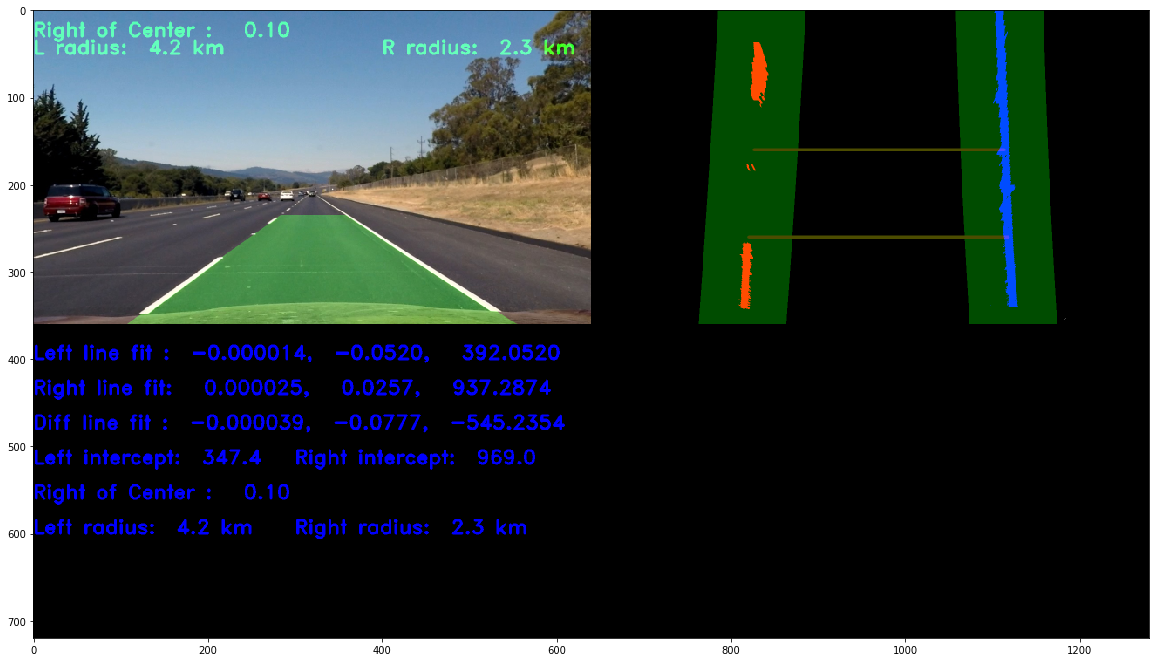

In [1108]:
frame_count = 0
l_line = Line()
r_line = Line()
debug_data = DebugData()
process_data = ProcessData(debug=True)

image = mpimg.imread('test_images/straight_lines2.jpg')
finalimg = process_image(image, display=False)
finalimg = process_image(image, display=False)
plt.figure(figsize=(20, 20))
plt.imshow(finalimg)
plt.show()


In [1032]:
print(debug_data.framecount)
print(debug_data.need_update())
#t = np.ndarray(debug_data.left_fit)
np.histogram(debug_data.left_fit)
debug_data.left_fit
np.histogram(debug_data.yd1, 20)

2
None


(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([ 617.5 ,  617.55,  617.6 ,  617.65,  617.7 ,  617.75,  617.8 ,
         617.85,  617.9 ,  617.95,  618.  ,  618.05,  618.1 ,  618.15,
         618.2 ,  618.25,  618.3 ,  618.35,  618.4 ,  618.45,  618.5 ]))

In [1098]:
### Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
# Set up lines for left and right
l_line = Line()
r_line = Line()
debug_data = DebugData()
process_data = ProcessData(debug=True)

video_debug_output1 = 'project_video_debug_output.mp4'
video_input1 = VideoFileClip('project_video.mp4')#.subclip(22,30)
processed_video = video_input1.fl_image(process_image)
%time processed_video.write_videofile(video_debug_output1, audio=False)


[MoviePy] >>>> Building video project_video_debug_output.mp4
[MoviePy] Writing video project_video_debug_output.mp4



 12%|█▏        | 152/1261 [01:25<09:15,  2.00it/s]


 24%|██▍       | 303/1261 [02:34<09:38,  1.65it/s]


 36%|███▌      | 454/1261 [03:39<05:29,  2.45it/s]


 48%|████▊     | 605/1261 [04:40<04:56,  2.21it/s]


 60%|█████▉    | 756/1261 [05:50<03:21,  2.51it/s]


 72%|███████▏  | 907/1261 [06:48<02:13,  2.66it/s]


 84%|████████▍ | 1057/1261 [07:53<01:20,  2.53it/s]


 96%|█████████▌| 1205/1261 [08:49<00:20,  2.73it/s]


100%|█████████▉| 1260/1261 [09:10<00:00,  2.78it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_debug_output.mp4 

CPU times: user 9min 41s, sys: 2min 11s, total: 11min 52s
Wall time: 9min 11s


In [1099]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_debug_output1))

In [1104]:
l_line = Line()
r_line = Line()
debug_data = DebugData()
process_data = ProcessData()

video_output1 = 'project_video_output.mp4'
video_input1 = VideoFileClip('project_video.mp4')#.subclip(22,30)
processed_video = video_input1.fl_image(process_image)
%time processed_video.write_videofile(video_output1, audio=False)


[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4



 12%|█▏        | 152/1261 [01:12<09:35,  1.93it/s]


 24%|██▍       | 303/1261 [02:25<06:34,  2.43it/s]


 36%|███▌      | 454/1261 [03:27<04:24,  3.05it/s]


 48%|████▊     | 605/1261 [04:19<03:36,  3.04it/s]


 60%|█████▉    | 756/1261 [05:11<02:47,  3.01it/s]


 72%|███████▏  | 907/1261 [06:16<03:02,  1.94it/s]


 84%|████████▍ | 1057/1261 [07:14<01:10,  2.89it/s]


 96%|█████████▌| 1205/1261 [08:05<00:18,  3.02it/s]


100%|█████████▉| 1260/1261 [08:26<00:00,  2.81it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 8min 53s, sys: 1min 59s, total: 10min 53s
Wall time: 8min 28s


In [1106]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output1))

[MoviePy] >>>> Building video harder_challenge_video_output.mp4
[MoviePy] Writing video harder_challenge_video_output.mp4



 13%|█▎        | 152/1200 [00:44<06:57,  2.51it/s]


 25%|██▌       | 303/1200 [01:48<05:15,  2.84it/s]


 38%|███▊      | 454/1200 [03:07<06:19,  1.96it/s]


 50%|█████     | 605/1200 [04:13<03:58,  2.49it/s]


 63%|██████▎   | 756/1200 [05:30<03:19,  2.22it/s]


 76%|███████▌  | 907/1200 [06:35<01:26,  3.37it/s]


 77%|███████▋  | 921/1200 [06:39<01:21,  3.44it/s]

(4129,)
(4129,)
[False False False ...,  True  True  True]
[False False False ..., False False False]
<class 'numpy.ndarray'>
(3829,)


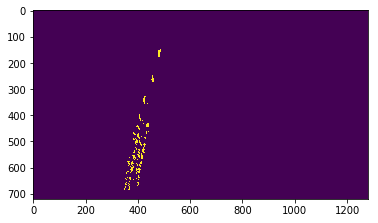


 89%|████████▉ | 1071/1200 [07:30<00:48,  2.67it/s]


100%|█████████▉| 1199/1200 [08:17<00:00,  2.55it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_video_output.mp4 

CPU times: user 8min 50s, sys: 1min 43s, total: 10min 34s
Wall time: 8min 18s


In [1110]:
l_line = Line()
r_line = Line()
debug_data = DebugData()
process_data = ProcessData(debug=True)

video_output2 = 'harder_challenge_video_output.mp4'
video_input2 = VideoFileClip('harder_challenge_video.mp4')#.subclip(0,16)
processed_video = video_input2.fl_image(process_image)
%time processed_video.write_videofile(video_output2, audio=False)


In [1111]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output2))